In [2]:
import argparse
import numpy as np
import json
import random
import keras
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.
/home/iranildo/anaconda3/envs/paic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/iranildo/anaconda3/envs/paic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/iranildo/anaconda3/envs/paic/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/iranildo/anaco

In [3]:
batch_size=256
top_n=5
model_type="l2ac"
set_mode="train1"
db="amazon"
ncls=9

out_dir="../runs/l2ac_5_9/0/"

output_fn=out_dir+"train.h5"
eval_fn=out_dir+"eval.h5"
data=np.load("../"+db+"/data/"+set_mode+"_idx.npz")

In [4]:
train_X0=np.repeat(data['train_X0'], ncls, axis=0)
train_X1=data['train_X1'][:,-ncls:,-top_n:].reshape(-1, top_n)
train_Y=data['train_Y'][:,-ncls:].reshape(-1,)
valid_X0=np.repeat(data['valid_X0'], 2, axis=0) #the validation data is balanced.
valid_X1=data['valid_X1'][:,-2:,-top_n:].reshape(-1, top_n)
valid_Y=data['valid_Y'][:,-2:].reshape(-1,)

In [5]:
print(data.files)

['train_rep', 'train_Y', 'valid_X1', 'train_X0', 'valid_Y', 'train_X1', 'valid_X0']


In [6]:
query=keras.Input(shape=(data['train_rep'].shape[1],), dtype="float32" )
x_rep=query
x1=keras.Input(shape=(top_n, data['train_rep'].shape[1]), dtype="float32" )
x1_rep=x1

In [7]:
print(data['train_rep'].shape)
print(data['train_rep'])

(100000, 512)
[[0.         0.00376278 0.         ... 0.         0.04510138 0.0141681 ]
 [0.         0.         0.03986862 ... 0.         0.08018569 0.01789098]
 [0.         0.05254612 0.02741214 ... 0.         0.05547189 0.00843837]
 ...
 [0.         0.02203734 0.02549556 ... 0.47996774 0.00141776 0.01909813]
 [0.         0.         0.         ... 0.03336517 0.         0.00200262]
 [0.         0.         0.0822084  ... 0.00569493 0.00078439 0.01160259]]


In [8]:
print(query)
print(x1)

Tensor("input_1:0", shape=(?, 512), dtype=float32)
Tensor("input_2:0", shape=(?, 5, 512), dtype=float32)


In [9]:
#"many_lstm_simspace"
x_rep=keras.layers.RepeatVector(train_X1.shape[1] )(x_rep)
if "abssub" in model_type:
    x_sub=keras.layers.Subtract()([x_rep, x1_rep])
    x_rep=keras.layers.Lambda(lambda x: K.abs(x) )(x_sub)
elif "sum" in model_type:
    x_rep=keras.layers.Add()([x_rep, x1_rep])
else:
    x_sub=keras.layers.Subtract()([x_rep, x1_rep])
    x_abs=keras.layers.Lambda(lambda x: K.abs(x) )(x_sub)
    x_add=keras.layers.Add()([x_rep, x1_rep])
    x_rep=keras.layers.Concatenate(axis=-1)([x_abs, x_add])

In [10]:
x_rep=keras.layers.Dense(512, activation="relu")(x_rep)
x_rep=keras.layers.Dropout(0.5)(x_rep)
if top_n>1: #do not use lstm when only have one example per class
    x_rep=keras.layers.Dense(1, activation="sigmoid")(x_rep)
    x_rep=keras.layers.Bidirectional(keras.layers.CuDNNLSTM(1) )(x_rep)
    #x_rep=keras.layers.Bidirectional(keras.layers.LSTM(1) )(x_rep)
else:
    x_rep=keras.layers.Reshape((-1,) )(x_rep)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
output=keras.layers.Dense(1, activation="sigmoid")(x_rep)
matching_model=keras.engine.Model([query, x1], output)
mem_layer=keras.layers.Embedding(data['train_rep'].shape[0], data['train_rep'].shape[1], weights=[data['train_rep'] ], trainable=False)
x=keras.Input(shape=(train_X0.shape[1],), dtype="int32" )
x_rep=keras.layers.Reshape((-1,) )(mem_layer(x) )
x1=keras.Input(shape=(train_X1.shape[1],), dtype="int32" )
x1_rep=mem_layer(x1)
output=matching_model([x_rep, x1_rep])
train_model=keras.engine.Model([x, x1], output)
train_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=["acc"])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
print(matching_model.summary())
print(train_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 512)       0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 5, 512)       0                                            
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 5, 512)       0           repeat_vector_1[0][0]            
                                                                 input_2[0][0]                    
__________

In [13]:
history=train_model.fit([train_X0, train_X1 ], train_Y, class_weight={0: 1./ncls, 1: (ncls-1.)/ncls}, 
                  validation_data=([valid_X0, valid_X1], valid_Y), 
                  batch_size=batch_size, epochs=50, verbose=0,
                  callbacks=[
                     keras.callbacks.ModelCheckpoint(output_fn, save_best_only=True) ]  )

In [14]:
train_model.load_weights(output_fn)
output=matching_model([query, x1_rep])
eval_model=keras.engine.Model([query, x1], output)
eval_model.save(eval_fn)

In [46]:
eval_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             51200000    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            525348      input_1[0][0]                    
                                                                 embedding_1[1][0]                
Total para

In [67]:
a,b = train_model.evaluate([train_X0, train_X1 ], train_Y, batch_size=batch_size, verbose=0)
print("Valor de perda(Data Train): %f"%a)
print("Valor da precisao(Data Train): %f"%b)
print()
a,b = train_model.evaluate([valid_X0, valid_X1 ], valid_Y, batch_size=batch_size, verbose=0)
print("Valor de perda(Data Validation): %f"%a)
print("Valor da precisao(Data Validation): %f"%b)

Valor de perda(Data Train): 0.266401
Valor da precisao(Data Train): 0.918915

Valor de perda(Data Validation): 0.331402
Valor da precisao(Data Validation): 0.872200


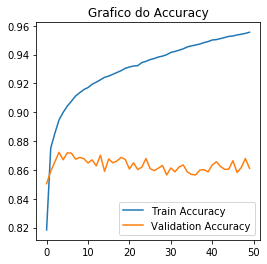

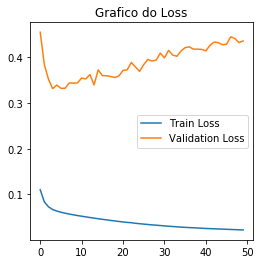

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.plot(history.history['acc'],label="Train Accuracy")
plt.plot(history.history['val_acc'],label="Validation Accuracy")
plt.legend()
plt.title('Grafico do Accuracy')

plt.figure(figsize=(4,4))
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'],label="Validation Loss")
plt.legend()
plt.title('Grafico do Loss')

plt.show()